In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

<img src="Imagenes/fig3.png" width="500" > >

## Respuesta 1

$$
f''(x) + \frac{f'(x)}{x}= \frac{dU}{df},
$$

donde $U= \frac{n^2 f^2}{2x^2} + \frac{\lambda}{4}\left(f(x)^2-v^2\right)^2$. Analizando la solución del la EDO alrededor de $x=0$ encontramos que $f\sim r^n$ para asegurar regularidad en el origen. Lo que nos lleva a proponer el siguiente cambio de variable $f = x^n \sigma(x)$ quedando la EDO como:

$$
\sigma''(x) + \frac{(1+2 n)}{x}\sigma'(x) = \frac{dV}{d\sigma},
$$

donde ahora $V=\frac{\lambda}{4}(x^{2n} \sigma^2-2 v^2) \sigma^2$. En el problema nos piden que en $\lim_{x\to \infty} f(x) = v$, lo que se traduce a la condición $\sigma(x_{max})=v/x_{max}^n$

In [3]:
def sysEq(x, yval, v, lam, n):
    """ 
    """
    s, ds = yval
    
    if x==0:
        f1 = ds
        f2 = -v**2*lam*s/2/(1+n)
    else:
        f1 = ds
        f2 = -v**2*lam*s + x**(2*n)*s**3 - (1+2*n)*ds/x
        
    return [f1, f2]
    

# Implementacion
def RKMet(func, data, arg=None, rk='rk5'):
    """
    Implementacion del metodo de  Runge Kutta de orden 4 y 5

    In:
    func -> Sistema de EDO, debe tener la estructura:
            (x, yval, a, b, ..) donde a, b, .. son argumentos que se han de pasar como listas a la variable arg
    
    data -> Es una lista [y0v, a, b, npt] que proporciona la información necesaria para la implementación del RK donde
            y0v ->  es una lista con las condiciones de frontera en r=a
            a, b -> rmin, rmax
            npt -> son los números de puntos usados para generar h = (b-a)/(npt-1)
    arg -> argumentos que se le pasarán al sistema de ecuaciones
    rk -> el método que se utilizará puede ser 'rk4' o 'rk5', por defecto está el 'rk5'

    Out:
    xval -> un arreglo discreto de valores de ri, donde se itero  
    yval -> una lista de arreglos discretos correspondientes a las iteraciones con la misma estructura que y0v. Cada fila corresponde a un ri.
    """
    if arg:
        f = lambda x, yv: np.array(func(x, yv, *arg))
    else:
        f = lambda x, yv: np.array(func(x, yv))
    
    if rk == 'rk5':
        xval, yval = rk5Gene(f, data)
    else:
        xval, yval = rk4Gene(f, data)
    
    return xval, yval
    

def rk4Gene(f, data):
    y0v, a, b, npt = data

    # h val
    h = (b-a)/(npt-1)
    xval = a + np.arange(npt)*h
    nEq = len(y0v)
    yval = np.zeros((npt, nEq))  # crea una matriz (npt, nEq)
    
    yv = np.copy(y0v)
    for j, xi in enumerate(xval):
        yval[j, :] = yv
        k0 = h*f(xi, yv)  # importante como se define la función, tiene que ser de la forma f(x, yv) donde yv=[y0, y1, ...]
        k1 = h*f(xi+h/2, yv+k0/2)
        k2 = h*f(xi+h/2, yv+k1/2)
        k3 = h*f(xi+h, yv+k2)
        yv = yv + (k0 + 2*k1 + 2*k2 + k3)/6
        #yv += (k0 + 2*k1 + 2*k2 + k3)/6
           
    return xval, yval

def rk5Gene(f, data):
    """
    Implementacion del metodo de  Runge Kutta de orden 5

    In:
    func -> Sistema de EDO, debe tener la estructura:
            (x, yval, a, b, ..) donde a, b, .. son argumentos que se han de pasar como listas a la variable arg
    
    data -> Es una lista [y0v, a, b, npt] que proporciona la información necesaria para la implementación del RK donde
            y0v ->  es una lista con las condiciones de frontera en r=a
            a, b -> rmin, rmax
            npt -> son los números de puntos usados para generar h = (b-a)/(npt-1)
    
    Out:
    xval -> un arreglo discreto de valores de ri, donde se itero  
    yval -> una lista de arreglos discretos correspondientes a las iteraciones con la misma estructura que y0v. Cada fila corresponde a un ri.
    """
    y0v, a, b, npt = data

    # h val
    h = (b-a)/(npt-1)
    xval = a + np.arange(npt)*h
    nEq = len(y0v)
    yval = np.zeros((npt, nEq))  # crea una matriz (npt, nEq)
    
    yv = np.copy(y0v)
    for j, xi in enumerate(xval):
        yval[j, :] = yv
        k0 = h*f(xi, yv)  # importante como se define la función, tiene que ser de la forma f(x, yv) donde yv=[y0, y1, ...]
        k1 = h*f(xi+h/4, yv+k0/4)
        k2 = h*f(xi+3*h/8, yv+3*k0/32+9*k1/32)
        k3 = h*f(xi+12/13*h, yv+1932*k0/2197-7200*k1/2197+7296*k2/2197)
        k4 = h*f(xi+h, yv+439*k0/216-8*k1+3680*k2/513-845*k3/4104)
        k5 = h*f(xi+h/2, yv-8*k0/27+2*k1-3544*k2/2565+1859*k3/4104-11*k4/40)
        yv = yv + 16*k0/135 + 6656*k2/12825 + 28561*k3/56430-9*k4/50 + 2*k5/55
    return xval, yval

In [4]:
from Complementos.root.BS import roo_Bis
from scipy.integrate import solve_ivp

# implementación
def shoot(func, sig, dsig, x0, xmax, npt, arg=None, info=False, RK=False):
    v, _, n = arg
    yf = v/xmax**n
    
    y0v = [sig, dsig]
    data = [y0v, x0, xmax, npt] 
    
    if RK: 
        xval, ys = RKMet(func, data, arg=arg)
    else:
        if arg:
            f = lambda x, yv: np.array(func(x, yv, *arg))
        else:
            f = lambda x, yv: np.array(func(x, yv))
        
        
        xvalI = np.linspace(x0, xmax, npt)
        sol = solve_ivp(f, [x0, xmax], y0v, t_eval=xvalI, method='RK45', rtol=1e-09, atol=1e-10)  # ='RK45' DOP853
        xval, ys =  sol.t, sol.y[0]
    
    if info:
        if RK:
            plt.plot(xval, xval**n*ys[:, 0])
        else:
            plt.plot(xval, xval**n*ys)
        plt.hlines(y=v, xmin=x0, xmax=xmax)
        plt.show()
    
    if info:
        if RK:
            print('yf -> ', yf,  'Itera -> ', ys[-1, 0], 'Dif -> ', ys[-1, 0]-yf, ' ', 'sigma -> ', sig)
        else:
            print('yf -> ', yf,  'Itera -> ', ys[-1], 'Dif -> ', ys[-1]-yf, ' ', 'sigma -> ', sig)
    
    if RK:
        dif = ys[-1, 0]-yf
    else:
        dif = ys[-1]-yf
            
    return dif

def shooting(func, datos, arg=None, inter=[-1e10, 1e10], Nit=1000, Ndiv=100, eps=1e-05, info=False, RK=False):
    dsig, x0, xmax, npt = datos
    sol2 = lambda sig: shoot(func, sig, dsig, x0, xmax, npt, arg=arg, info=info, RK=RK)
    yder = roo_Bis(sol2, inter, Nit=Nit, error='dist', eps=eps, Ndiv=Ndiv) 
    return yder

In [8]:
dsig = 0  # y1=15 # 0.58
x0, xmax = 0, 13
npt = 5000
datos = [dsig, x0, xmax, npt]
v, lam, n = 1, 1, 2

derVal = shooting(sysEq, datos, arg=[v, lam, n], inter=[0, 0.5],
                  Nit=1000, Ndiv=1000, eps=1e-08, info=False, RK=False)
derVal

[0.15309910588078313]

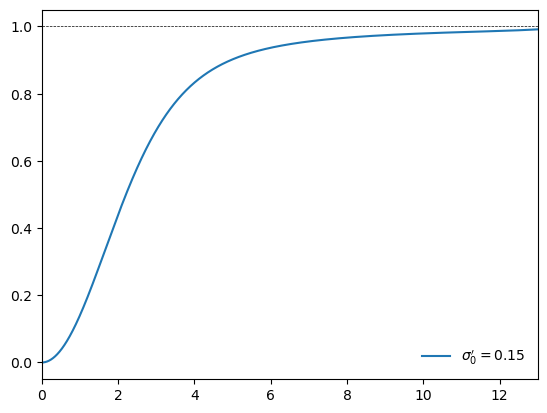

In [14]:
arg = [v, lam, n]
xvalI = np.linspace(x0, xmax, npt)
f = lambda x, yv: np.array(sysEq(x, yv, *arg))

dsig = 0
sig = derVal[0]
y0v = [sig, dsig]
        
sol = solve_ivp(f, [x0, xmax], y0v, t_eval=xvalI, method='RK45', rtol=1e-09, atol=1e-10)

plt.plot(sol.t, sol.t**n*sol.y[0], label=r'$\sigma_0^{\prime}=%3.2f$'%sig)
plt.hlines(y=v, xmin=x0, xmax=xmax, ls='--', color='k', lw=0.5)
plt.xlim(x0, xmax)
plt.legend(loc='lower right', frameon=False)
plt.show()
